![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

# Risk measures

The value-at-risk (VaR) of a random variable $X$ at risk level $\alpha$ is defined as
$$\textrm{VaR}_\alpha(X) = \min_\eta\left(\mathbb{P}[X\geq\eta]\leq 1-\alpha\right)$$
and the conditional value-at-risk (CVaR) is the conditional expected value
$$\textrm{CVaR}_\alpha(X)=\mathbb{E}(X~|~X\geq\textrm{VaR}_\alpha(X)).$$
In the standard setting where the random variable $X$ represents a loss (on an investment) and we take $\alpha=0.9$, CVaR can be interpreted as the expected loss assuming we end up in the $10\%$ worst scenarios. The concept was studied in the paper <a href="http://www.ise.ufl.edu/uryasev/files/2011/11/CVaR1_JOR.pdf">Optimization of Conditional Value-at-Risk</a>, Rockafellar and Uryasev, Journal of Risk, 2002, where we also find an equivalent formula
$$\textrm{CVaR}_\alpha(X)=\min_\eta\left(\eta+(1-\alpha)^{-1}\mathbb{E}([X-\eta]^+)\right)$$
where $[x]^+=\max(x,0)$.

Some authors consider generalizations
$$\rho^f_\alpha(X)=\min_\eta\left(\eta+(1-\alpha)^{-1}f^{-1}\left(\mathbb{E}(f(X-\eta))\right)\right),$$
where $f$ is any increasing, convex function on $\mathbb{R}_+$ which is identically zero on $\mathbb{R}_-$. Examples include:
* $f(x)=[x]^+$, recovering the previous definition of CVaR,
* $f(x)=\exp([t]^+)-1$, log-exponential convex risk measure (LogExpCR), <a href="https://doi.org/10.1016/j.disopt.2016.07.002">(Vinel, Krokhmal 2017)</a>,
* $f(x)=([x]^+)^q$, higher moment coherent risk measures (HMCR) <a href="https://doi.org/10.1080/14697680701458307">(Krokhmal 2007)</a>.

# Stochastic portfolio optimization

In this notebook we implement the models described in Section 5 of <a href="https://doi.org/10.1016/j.disopt.2016.07.002">(Vinel, Krokhmal 2017)</a> with various risk measures. We consider the problem of investing in $n$ stocks given $m$ historical return vectors $r_1,\ldots,r_m\in\mathbb{R}^n$  taken with probabilities $p_1,\ldots,p_m$. We consider the following conditions:
* total budget constraint:
  $$1^Tx\leq 1$$
* minimal expected return:
  $$x^T\mathbb{E}(\mu)\geq \bar{r}$$
  where $\mu$ is the uncertain vector of returns, $\mathbb{E}(\mu)=\sum_j p_jr_j$ is its expected value averaged over the historical scenarios, and $\bar{r}$ is the minimal required expected return level.
* no short-selling:
  $$x\geq 0$$
* the objective represents minimization of CVaR $\rho^f_\alpha(-\mu^Tx)$ of the loss $-\mu^Tx$, that is
  $$\textrm{minimize}_{\eta,x}\left(\eta+(1-\alpha)^{-1}f^{-1}(\sum_{j=1}^mp_jf(-r_j^Tx-\eta))\right)$$
  
We used a preprocessed file with closing prices from NYSE for 1675 assets over 2050 trading days. Each historical scenario is defined by computing returns of all assets over some period of 10 trading days They are returned in a martix $r$ with $n$ rows and $m$ columns.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mosek.fusion import *
import mosek.fusion.pythonic
import numpy as np 
import sys, os, csv

allPrices = np.array(list(csv.reader(open("allPrices.txt"), lineterminator='\n', quoting=csv.QUOTE_NONNUMERIC)))
n,m = allPrices.shape
p1  = allPrices[:,0:m-10]
p2  = allPrices[:,10:m]
r   = (p2-p1)/p1
print(r.shape)

(1675, 2040)


# CVaR

We first implement the linear CVaR model with $f(x)=[x]^+$. We can then write the problem as

$$
\begin{array}{ll}
\mbox{minimize} &  \eta + (1-\alpha)^{-1} p^Tw\\
\mbox{subject to} & 1^Tx\leq 1, \\
 & x^Trp\geq \bar{r}, \\
 & w_j\geq \max\{0, -r_j^Tx-\eta \}, \quad j=1,\ldots,m,
\end{array}
$$

with variables $x\in\mathbb{R}^n, w\in\mathbb{R}^m, \eta\in\mathbb{R}$. Below is the Fusion implementation.

In [2]:
def modelCVaR(alpha, rbar, p, r, m, n):   
    M = Model("CVaR")

    # Variables
    X   = M.variable('X', n, Domain.greaterThan(0.0))
    W   = M.variable('W', m, Domain.greaterThan(0.0))
    eta = M.variable('eta')

    # The bounds w_j + r_j^Tx + eta \geq 0
    M.constraint(W + r.T @ X + Var.vrepeat(eta, m) >= 0)
    # Minimal risk
    M.constraint(X.T @ (r @ p) >= rbar) 
    # Budget
    M.constraint(Expr.sum(X) <= 1.0)

    # Set the objective 
    M.objective(ObjectiveSense.Minimize, eta + W.T @ p / (1-alpha))

    return M

# LogExpCR

Next we have $f(x)=\exp([x]^+)-1$. Since $\sum_j p_j=1$, the model can equivalently be formulated as

$$
\begin{array}{ll}
\mbox{minimize} &  \eta + (1-\alpha)^{-1} t\\
\mbox{subject to} & 1^Tx\leq 1, \\
 & x^Trp\geq \bar{r}, \\
 & w_j\geq \max\{0, -r_j^Tx-\eta \}, \quad j=1,\ldots,m, \\
 & t\geq \log\left(\sum_j p_j\exp(w_j)\right).
\end{array}
$$

The last bound (log-sum-exp constraint) can be expressed using an auxiliary variable $\xi\in\mathbb{R}^m$:

$$
\begin{array}{l}
p^T\xi \leq 1, \\
\xi_j\geq \exp(w_j-t),
\end{array}
$$

where the last inequality is conic-representable as $(\xi_j,1,w_j-t)\in K_\mathrm{exp}$.

In [3]:
def modelLogExpCR(alpha, rbar, p, r, m, n):   
    M = Model("LogExpCR")

    # Variables
    X   = M.variable('X', n, Domain.greaterThan(0.0))
    W   = M.variable('W', m, Domain.greaterThan(0.0))
    eta = M.variable('eta')
    xi  = M.variable('xi', m) 
    t   = M.variable('t') 

    # The log-sum-exp constraint
    M.constraint(xi.T @ p <= 1.0) 
    # Stack allcones together - every row has the form (xi_j, 1, w_j-t)
    # The matrix notation means that every row belongs to the cone
    M.constraint(Expr.hstack(xi, Expr.constTerm(m, 1.0), W - Var.vrepeat(t, m)), Domain.inPExpCone())

    # Continue with the linear constraints
    M.constraint(W + r.T @ X + Var.vrepeat(eta, m) >= 0)
    M.constraint(X.T @ (r @ p) >= rbar) 
    M.constraint(Expr.sum(X) <= 1.0)

    # Set the objective 
    M.objective(ObjectiveSense.Minimize, eta + t / (1-alpha))

    return M

# HMCR

The model using $f(x)=([x]^+)^q$ is the same as LogExpCR, except that the last constraint becomes

$$t\geq\left(\sum_j p_jw_j^q\right)^{1/q}.$$

This $q$-norm cone constraint is equivalent to

$$
\begin{array}{l}
t = 1^T\xi,\\
t^{1-1/q}\xi_j^{1/q}\geq |p_j^{1/q}w_j|
\end{array}
$$

where the last row is precisely a conic constraint involving the $3$-dimenional power cone with parameters $(1-1/q,1/q)$.

In [4]:
def modelHMCR(alpha, rbar, p, r, m, n, q):   
    M = Model("HMCR")

    # Variables
    X   = M.variable('X', n, Domain.greaterThan(0.0))
    W   = M.variable('W', m, Domain.greaterThan(0.0))
    eta = M.variable('eta')
    xi  = M.variable('xi', m) 
    t   = M.variable('t') 

    # The power cones representing the q-norm constraint
    M.constraint(t == Expr.sum(xi)) 
    M.constraint(Expr.hstack(Var.vrepeat(t, m), xi, Expr.mulElm(np.power(p, 1.0/q), W)), Domain.inPPowerCone(1.0-1.0/q))

    # Continue with the linear constraints
    M.constraint(W + r.T @ X + Var.vrepeat(eta, m) >= 0)
    M.constraint(X.T @ (r @ p) >= rbar) 
    M.constraint(Expr.sum(X) <= 1.0)

    # Set the objective 
    M.objective(ObjectiveSense.Minimize, eta + t / (1-alpha))

    return M

# Example

We solve a few problems with $n=100$ stocks and $m=2000$ sample historical scenarios.

    CVaR: status=ProblemStatus.PrimalAndDualFeasible time=0.20s


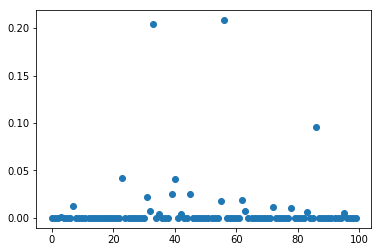

LogExpCR: status=ProblemStatus.PrimalAndDualFeasible time=0.69s


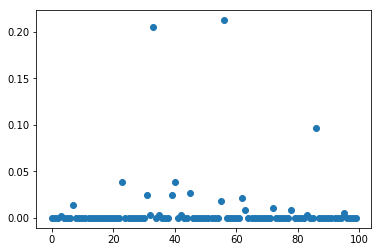

    HMCR: status=ProblemStatus.PrimalAndDualFeasible time=0.64s


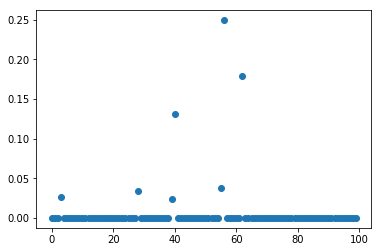

In [5]:
n, m    = 100,2000
alpha   = 0.9
rbar    = 0.005
p       = [1.0/m]*m   # Uniform probability

MCVaR     = modelCVaR(alpha, rbar, p, r[0:n,0:m], m, n)
MLogExpCR = modelLogExpCR(alpha, rbar, p, r[0:n,0:m], m, n)
MHMCR     = modelHMCR(alpha, rbar, p, r[0:n,0:m], m, n, q=5.9)

for M in [MCVaR, MLogExpCR, MHMCR]:
    M.setSolverParam("numThreads", 4)
    M.solve()
    print('{0: >8}: status={1} time={2:.2f}s'.format(M.getName(), M.getProblemStatus(), M.getSolverDoubleInfo("optimizerTime")))
    plt.plot(M.getVariable('X').level(), 'o')
    plt.show()


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 